In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad
from scipy.special import sph_harm
import pickle  # For saving and loading data
import os      # For file operations

In [32]:
def trigonometric_cache(theta, phi):
    s_theta = np.sin(theta)
    c_theta = np.cos(theta)
    s_phi = np.sin(phi)
    c_phi = np.cos(phi)
    return s_theta, c_theta, s_phi, c_phi


In [33]:
def pulsar_geometry_terms(xvec, theta, phi, trig_cache):
    s_theta, c_theta, s_phi, c_phi = trig_cache
    
    omega_hat = np.array([s_theta * c_phi, s_theta * s_phi, c_theta])
    m_hat = np.array([s_phi, -c_phi, 0])
    n_hat = np.array([c_theta * c_phi, c_theta * s_phi, -s_theta])
    
    e_plus = np.outer(m_hat, m_hat) - np.outer(n_hat, n_hat)
    e_cross = np.outer(m_hat, n_hat) + np.outer(n_hat, m_hat)
    
    pulsar = 0.5 * np.outer(xvec, xvec)
    
    f_plus = np.dot(e_plus, pulsar)
    f_cross = np.dot(e_cross, pulsar)
    
    denom = 1 + np.dot(omega_hat, xvec) + 1e-10  # Avoid division by zero
    
    d_plus = np.trace(f_plus / denom)
    d_cross = np.trace(f_cross / denom)
    
    factor = d_plus ** 2 + d_cross ** 2
    
    return d_plus, d_cross, factor


In [34]:
def integrand_circular_ylm(theta, phi, xvec, xve2_i, l, m):
    trig_cache = trigonometric_cache(theta, phi)
    d_plus_xvec, d_cross_xvec, _ = pulsar_geometry_terms(xvec, theta, phi, trig_cache)
    d_plus_xve2, d_cross_xve2, _ = pulsar_geometry_terms(xve2_i, theta, phi, trig_cache)
    
    # Spherical harmonic function Y_l^m(θ, φ)
    y_lm = sph_harm(m, l, phi, theta)  # Note: sph_harm(m, l, phi, theta)
    
    # Compute the integrand
    integrand = -1j * y_lm * (d_plus_xvec * d_cross_xve2 - d_cross_xvec * d_plus_xve2) * np.sin(theta) / (4 * np.pi)
    
    # Since we're integrating over real variables, return the real part
    return np.real(integrand)


In [53]:
def integrand_intensity_ylm(theta, phi, xvec, xve2_i, l, m):
    trig_cache = trigonometric_cache(theta, phi)
    d_plus_xvec, d_cross_xvec, _ = pulsar_geometry_terms(xvec, theta, phi, trig_cache)
    d_plus_xve2, d_cross_xve2, _ = pulsar_geometry_terms(xve2_i, theta, phi, trig_cache)
    
    # Spherical harmonic function Y_l^m(θ, φ)
    y_lm = sph_harm(m, l, phi, theta)  # Note: sph_harm(m, l, phi, theta)
    
    # Compute the integrand
    integrand =  y_lm * (d_plus_xvec * d_plus_xve2 + d_cross_xvec * d_cross_xve2) * np.sin(theta) / (4 * np.pi)
    
    # Since we're integrating over real variables, return the real part
    return np.real(integrand)

In [35]:
# Define the pulsar vector
xvec = np.array([0, 0, 1])

# Define the list of Xi values
Xi = np.linspace(0, np.pi, 61)  # 61 points from 0 to π

# Generate corresponding vectors xve2 for each Xi value
xve2 = [np.array([np.sin(xi), 0, np.cos(xi)]) for xi in Xi]


In [36]:
# Define the filename for saving the result
filename1 = 'result_circular_polarization_ylm.pkl'

# Check if the file already exists
if not os.path.exists(filename1):
    print("File not found. Running the calculations...")
    
    # Compute the result for circular polarization with spherical harmonics
    result_circular_polarization_ylm = []

    # Loop over xi values, l, and m
    for i in range(len(xve2)):
        intensity_lm = []
        for l in range(4):  # l from 0 to 3
            intensity_m = []
            for m in range(-l, l + 1):
                # Perform the integration over theta and phi
                res, _ = nquad(
                    integrand_circular_ylm,
                    [[0, np.pi], [0, 2 * np.pi]],
                    args=(xvec, xve2[i], l, m)
                )
                intensity_m.append(res)
            intensity_lm.append(intensity_m)
        result_circular_polarization_ylm.append(intensity_lm)
    
    # Save the result to a file using pickle
    with open(filename1, 'wb') as f:
        pickle.dump(result_circular_polarization_ylm, f)
    print(f"Calculation complete. Data saved to {filename1}")
else:
    # If the file exists, load the saved data
    with open(filename1, 'rb') as f:
        result_circular_polarization_ylm = pickle.load(f)
    print(f"Data loaded from {filename1}")


File not found. Running the calculations...


/home/mgurgeni/anaconda3/envs/enterprise/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Calculation complete. Data saved to result_circular_polarization_ylm.pkl


In [54]:
# Define the filename for saving the result
filename2 = 'result_intensity_ylm.pkl'

# Check if the file already exists
if not os.path.exists(filename2):
    print("File not found. Running the calculations...")
    
    # Compute the result for intensity  with spherical harmonics
    result_intensity_ylm = []

    # Loop over xi values, l, and m
    for i in range(len(xve2)):
        intensity_lm = []
        for l in range(4):  # l from 0 to 3
            intensity_m = []
            for m in range(-l, l + 1):
                # Perform the integration over theta and phi
                res, _ = nquad(
                    integrand_intensity_ylm,
                    [[0, np.pi], [0, 2 * np.pi]],
                    args=(xvec, xve2[i], l, m)
                )
                intensity_m.append(res)
            intensity_lm.append(intensity_m)
        result_intensity_ylm.append(intensity_lm)
    
    # Save the result to a file using pickle
    with open(filename2, 'wb') as f:
        pickle.dump(result_intensity_ylm, f)
    print(f"Calculation complete. Data saved to {filename2}")
else:
    # If the file exists, load the saved data
    with open(filename2, 'rb') as f:
        result_intensity_ylm = pickle.load(f)
    print(f"Data loaded from {filename2}")


File not found. Running the calculations...
Calculation complete. Data saved to result_intensity_ylm.pkl


In [57]:
def plot_ylm(data_ylm, data_xi,ylable):
    num_xi = len(data_xi)
    l_max = len(data_ylm[0]) - 1
    xi_values = data_xi

    # Start plotting from l = 1
    for l in range(0, l_max ):  
        plt.figure(figsize=(8, 6))
        # For each m in l, plot on the same axes
        for m in range(-l, l + 1):
            # Extract data points for a specific l and m
            data = [data_ylm[i][l][m + l] for i in range(num_xi)]
            # Plot data
            plt.plot(xi_values, data, label=f'm = {m}')
        plt.xlabel(r'$\Xi$')
        plt.ylabel(ylable)
        plt.title(f'Plot for l = {l}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

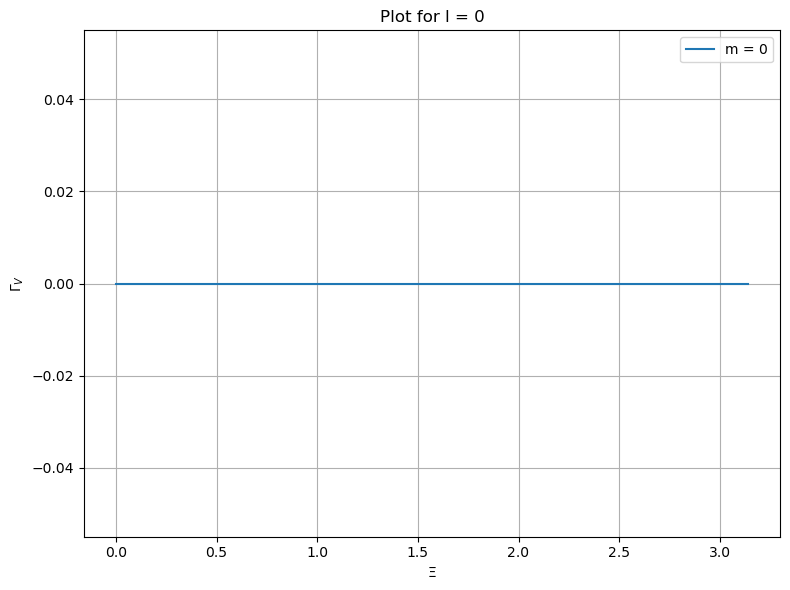

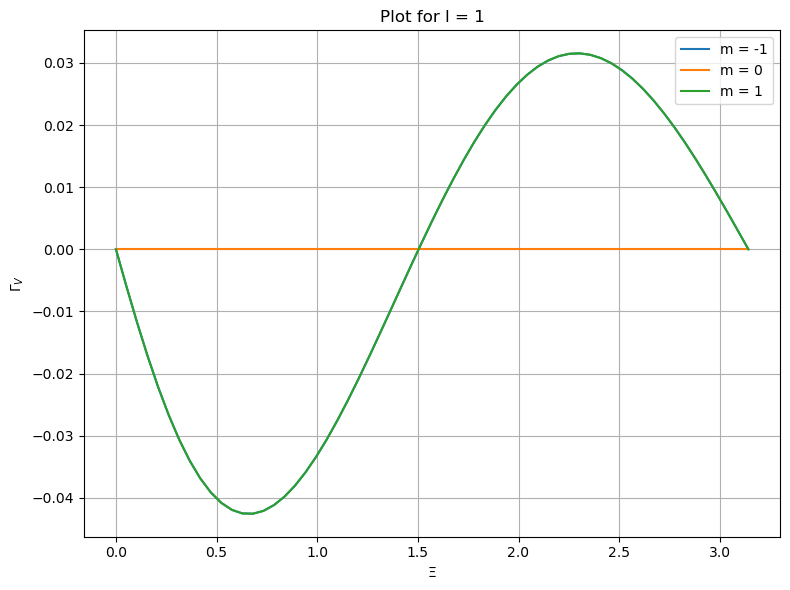

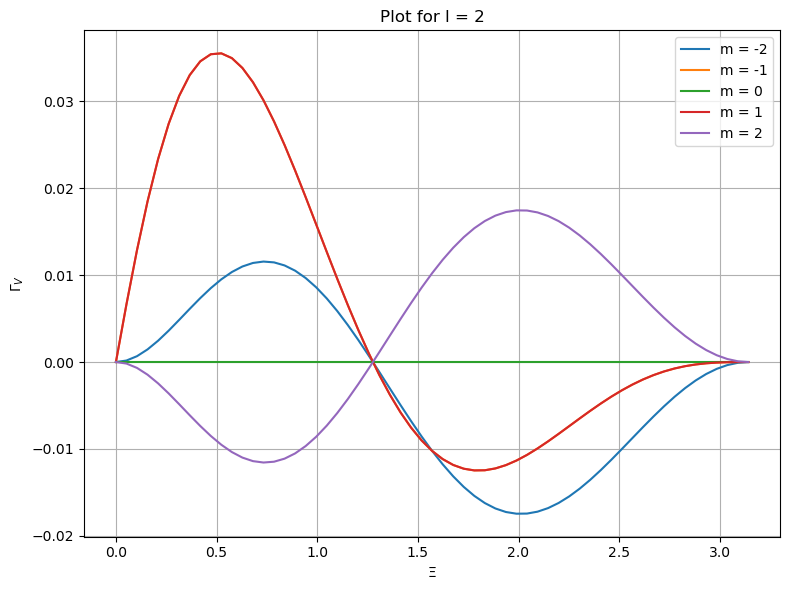

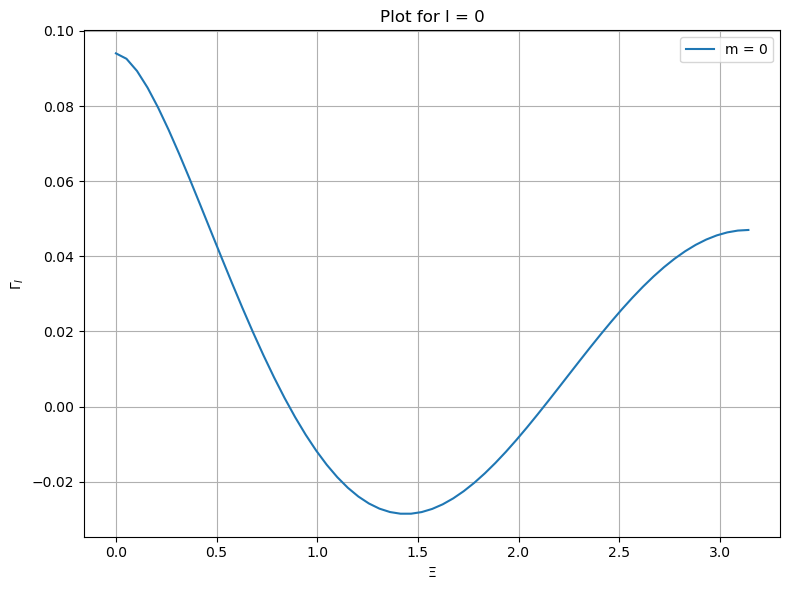

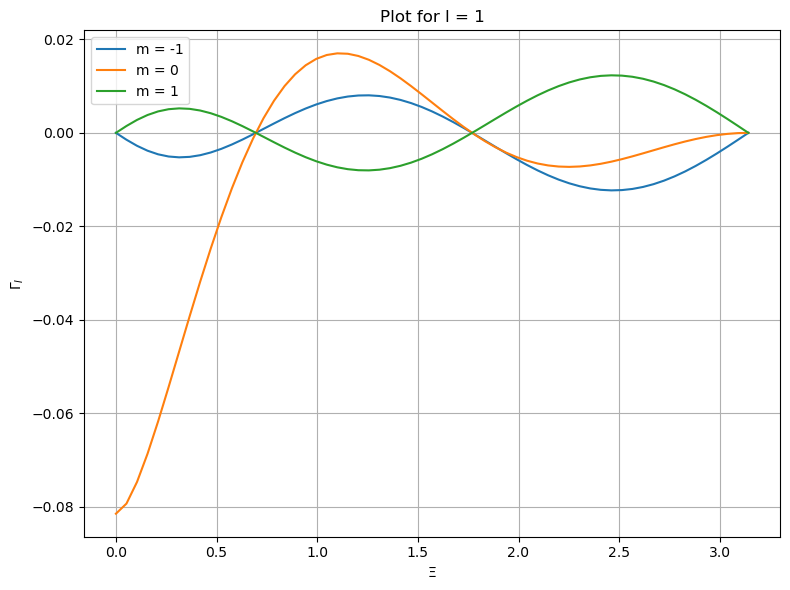

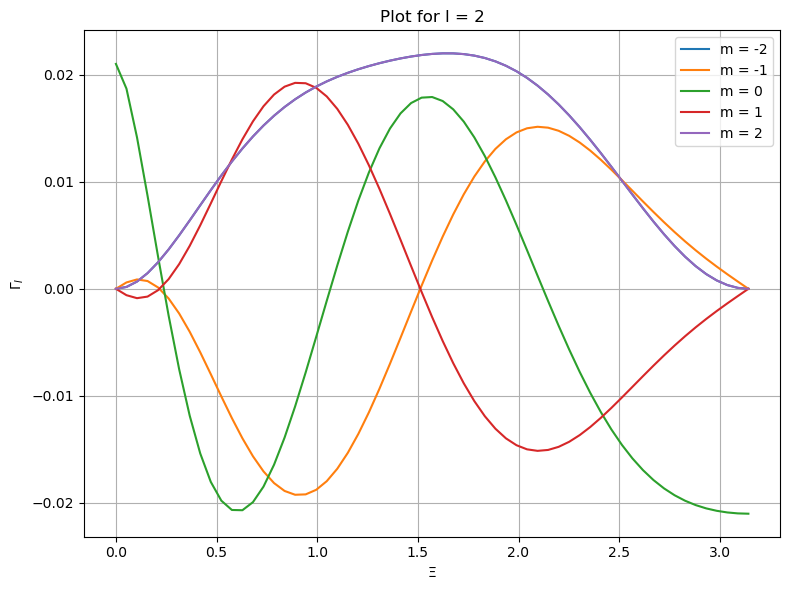

In [59]:
# Plot the results
plot_ylm(result_circular_polarization_ylm, Xi,r"$\Gamma_V$")
plot_ylm(result_intensity_ylm,Xi,r"$\Gamma_I$")
